# Lab9 - Spatial Data Analysis
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [50]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [2]:
import numpy as np
import pandas as pd
import pysal as ps
import seaborn as sns
import shapely

import statsmodels.api as sm
import matplotlib.pylab as plt

from geopandas import GeoDataFrame
from pandas import DataFrame
from fiona.crs import from_epsg
from matplotlib import colors
%matplotlib inline

## Working with Shape File

### Loading Census Tract Shape File¶

In [4]:

shape_path = "Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index = ct_shape.BoroCT2010

### Coordinate systems, projections, and transformations 

In [5]:

ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area = ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

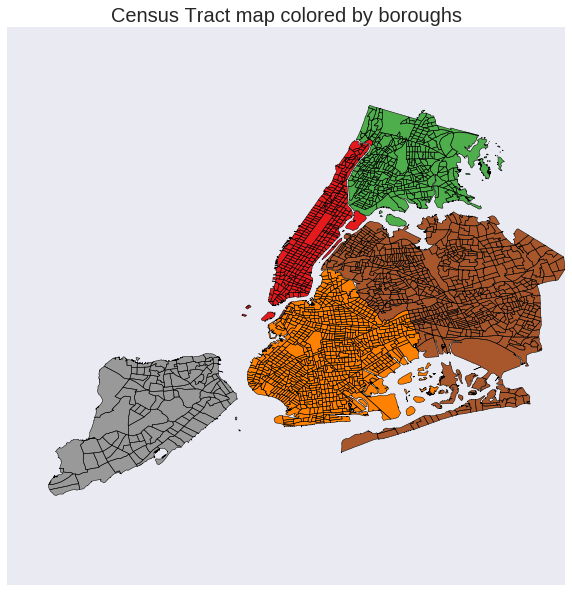

In [6]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column = 'BoroCode', alpha = 1, linewidth = 0.5, ax = ax)
plt.title("Census Tract map colored by boroughs", size = 20)

**Figure 1:** Map of Census Track of New York City colorored by boroughs.

### Map NYC Population density

#### Load Census Data for 2010

In [55]:
ct_data = DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index = ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [56]:
ct_shape_pop = ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

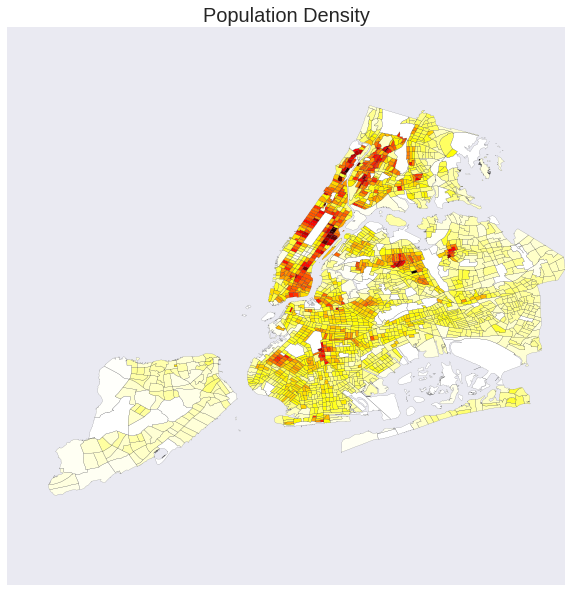

In [13]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density", size = 20)

** Figure 2: Map of population density.** The map shows the density of population in New York City. It can be seen that the area which are more dense are in in Manhattan. The area of the Upper East Side and some areas of the Bronx. Contrarly, Staten Island is the area with less density.

## Explore CitiBike data

### Load CitiBike data

In [58]:
df_bike_monthly = DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Time Series Aanalysis

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


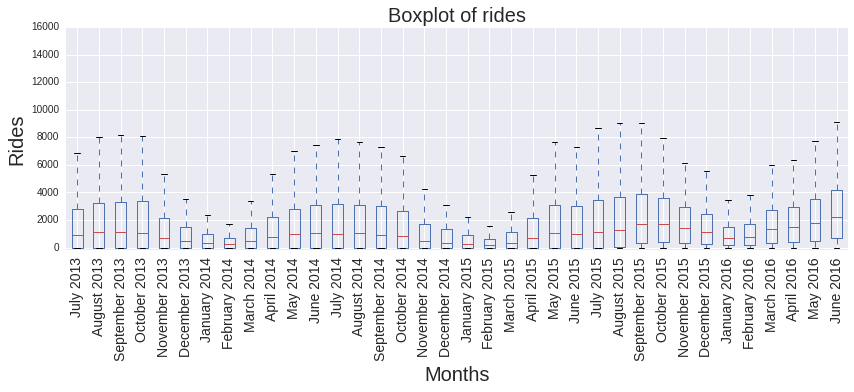

In [14]:
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))
#create a copy of the df for the viz purposes
df_bike_monthly_ = df_bike_monthly.copy()
df_bike_monthly_.index = df_bike_monthly_.index.strftime("%B %Y")
df_bike_monthly_.T.boxplot(figsize=(15,7),ax=ax,rot=90);
ax.set_ylim([-200,16000])

ax.set_title('Boxplot of rides', size = 20)
ax.set_ylabel('Rides', size = 20)
ax.set_xlabel('Months', size = 20)
plt.show()

**Figure 3: Boxplot of the rides corresponding to the months from 2013 until 2015**. It can be seen clearly that the set has a seasonal effect having more rides around summer.

#### Seasonal Decomposition

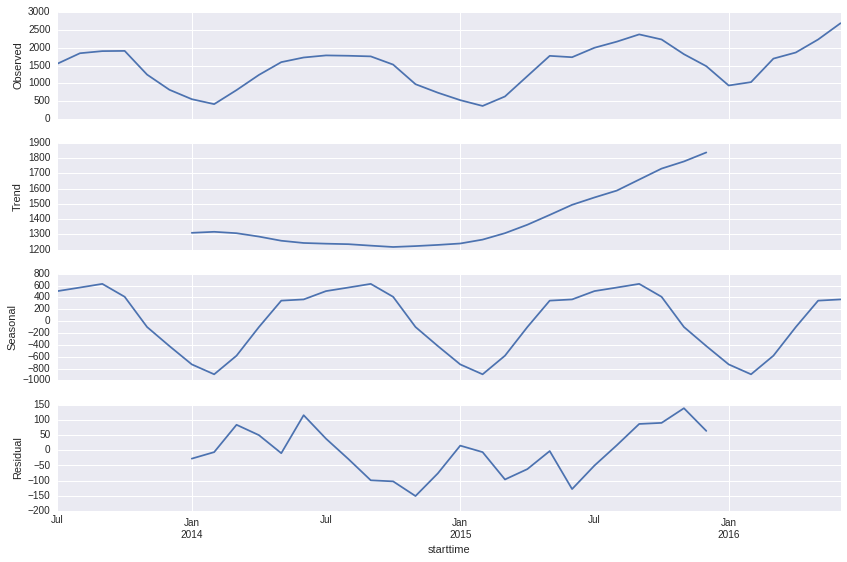

In [61]:
import statsmodels.api as sm

#Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

#Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

**Figure 4:** It shows the distribution of the rides. In the first plot , it can be seen the observed data (the whole set), then it can be that the trend is upward, and the third plot it can be seen where affects the seasonal effect to finish showing the residuals.

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [16]:
station_id = DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index = station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [17]:
# combine lat and lon to one column
station_id['lonlat'] = zip(station_id.lon,station_id.lat)
# Create Point Geometry for based on lonlat column
station_id['geometry'] = station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [18]:
a=[]
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [19]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly rides to the station GeoDataFrame with CT code

In [20]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve'] = df_bike_monthly.sum()

In [21]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,MonthlyAve
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,69308
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,102824
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,273525
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,101949
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,184044


### Add the monthly average rides to the CT shapefile 

In [22]:
# use the 
temp = station_id[['MonthlyAve']]
temp['station_id'] = station_id.index
temp.index = station_id['BoroCT2010']
ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


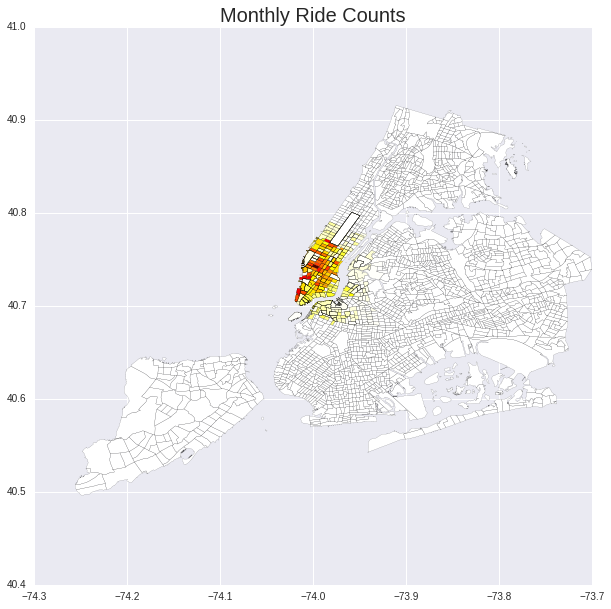

In [23]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts", size =20)

**Figure 5: Map that shows the Average Monthly rides.** This maps is a colorheat map that shows the average of the monthly rides. It can be seen that the area where people rides is Manhattan and a small part in Brooklyn. Of course , it is because there are no stations in other places

### Removing the CTs that are out of zoom boundries

In [24]:
ct_shape_MonthlyAve_Zoom = (ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and c.x<-73.92 and c.y>40.65 and c.y<40.8)])

In [25]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Map the monthly rides 

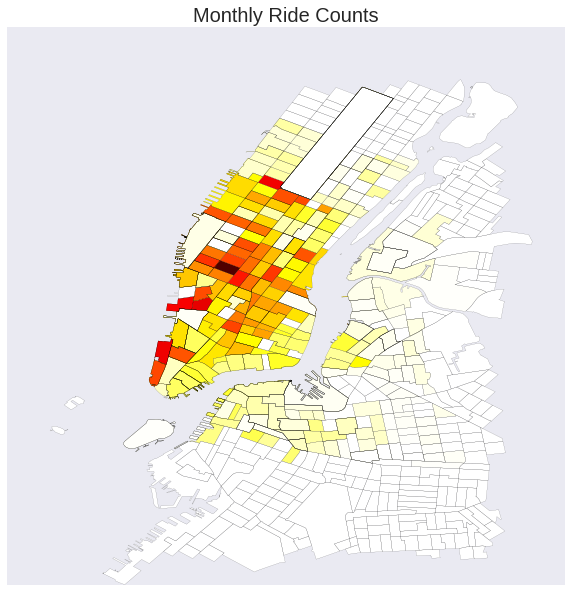

In [28]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Monthly Ride Counts", size =20)

**Figure 6: Map that shows the Average Monthly rides.** This maps is a zoom in into the area of the rides of the Figure 5. As well, it is a colorheat map that shows the average of the monthly rides during the summer period. It can be seen that the area where people rides is Manhattan and a small part in Brooklyn. Of course , it is because there are no station in other places. It can be seen that it is popular the area of lower Manhattan and Midtown and some areas nearby Central Park. 

### Export Shapefile CTs in the CitiBike Zone

In [29]:
path = 'Output/ct_shape_MonthlyAve_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [31]:
qW_CT = ps.queen_from_shapefile(path)

('Island id: ', [0])


#### Neighbors of index10

In [32]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [33]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [34]:
Wmatrix, ids = qW_CT.full()

In [35]:
Wmatrix

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [36]:
qW_CT.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [37]:
MonthlyRide = ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag = ps.lag_spatial(qW_CT, MonthlyRide)

#### Create Quantiles for maping

In [38]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10

                    Quantiles                    
 
  Lower                Upper                Count
             x[i] <=      0.000               140
     0.000 < x[i] <=    237.571                21
   237.571 < x[i] <=   4167.561                78
  4167.561 < x[i] <=  10026.857                80
 10026.857 < x[i] <=  17493.404                79
 17493.404 < x[i] <=  26977.053                80
 26977.053 < x[i] <=  58126.278                79
 58126.278 < x[i] <=  81788.042                80
 81788.042 < x[i] <=  96870.015                79
 96870.015 < x[i] <= 151983.357                80

#### Map the monthly rides lag

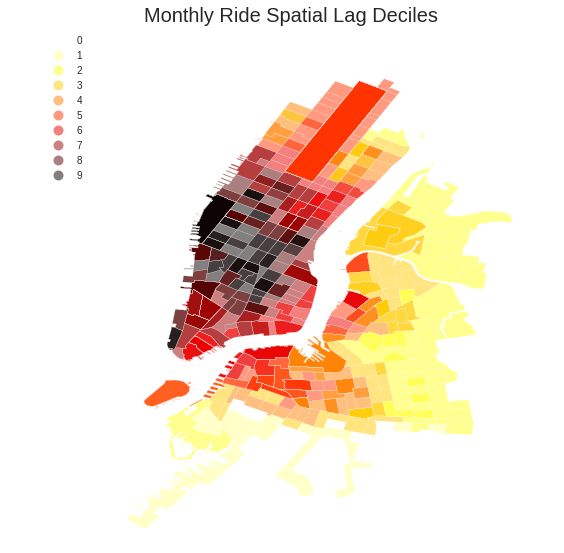

In [40]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles", size = 20)


**Figure 7: Map of Monthly Spatial Lag Deciles** It is a colorheat map that shows the similarity of the neighbourghs and how it will be influenced.

## Global  Spatial Autocorrelation

In [42]:
b,a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b,a 

(0.65563669282948467, 12557.637062387894)

### Moran Scatterplot

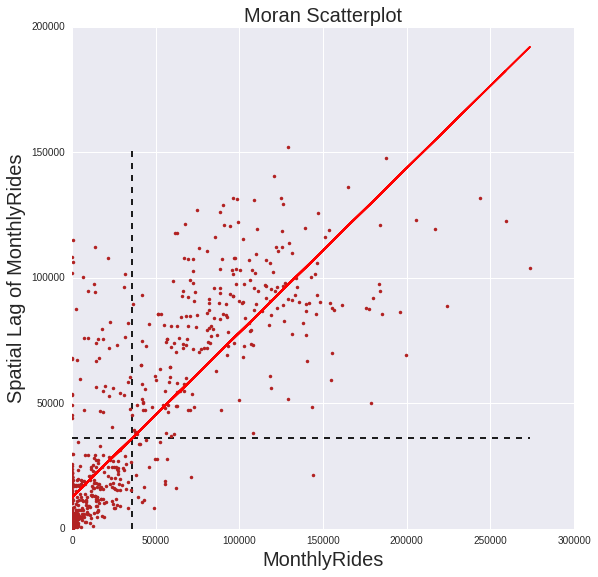

In [43]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot', size = 20)
plt.ylabel('Spatial Lag of MonthlyRides', size =20)
plt.xlabel('MonthlyRides', size =20)

**Figure 8: Scatterplot of rides.** This scatterplot shows the spaial autocorralation.It is represensent the  four quadrants (in dashed lines) where it can be seen that rides held into the first (upper-right) and the third (lower - left) indicating a positive autocorrelation. The red line represents the best fit using the I coefficient as slope.

### Moran's I

In [44]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)

In [45]:
I_MonthlyRide.I, I_MonthlyRide.p_sim

(0.65579332908409083, 0.001)

In [46]:
# El 0.001 numero es p-value.

Thus, the $I$ statistic is $0.656$ for this data, and has a very small $p$ value. 

In [47]:
I_MonthlyRide.sim[0:10]

array([-0.0184199 , -0.02156117, -0.00082463,  0.01305938, -0.02401178,
       -0.01054742,  0.01036864,  0.01975891,  0.00045652, -0.00290929])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [49]:
plt.rcParams['figure.figsize']=(14,3)

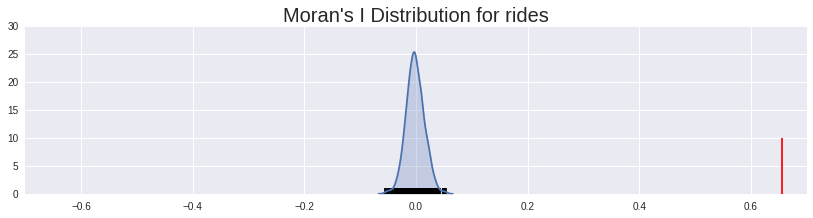

In [51]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.xlim([-.70, .70])

plt.title('Moran\'s I Distribution for rides', size = 20)
plt.show()

**Figure 9: Distribution for Moran's I for winter montly rides.** It can be seen that p value is very small and i is significant.


In the following figure the vertical line is showing if our $I$ statistic were close to our expected value

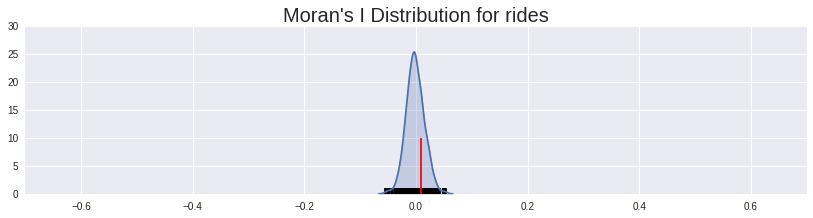

In [52]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'r')
plt.xlim([-.70, .70])

plt.title('Moran\'s I Distribution for rides', size = 20)
plt.show()

**Figure 10: Distribution for Moran's I for rides.** It shows that the I statistic is close to our expected value.

## Local  Spatial Autocorrelation

In [53]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)

In [54]:
LMo_MonthlyRide.Is[0:5], LMo_MonthlyRide.p_sim[0:5]

(array([-0.        , -0.25378156,  0.00285019,  0.00186   ,  0.00802061]),
 array([ 0.001,  0.164,  0.394,  0.388,  0.427]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [55]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

### Plot Signficant LISA

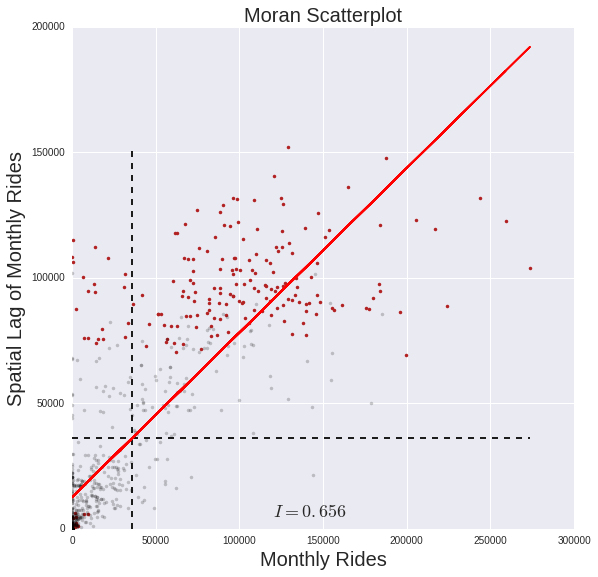

In [57]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot', size = 20)
plt.ylabel('Spatial Lag of Monthly Rides', size =20)
plt.xlabel('Monthly Rides', size =20)
plt.show()

**Figure 11: Moran Scatterplot for rides.** This scatterplot shows the rides that are significant in order to autocorrelation (red) and the ones which are not (grey). Also it is printed, the I of 0.656 and the fit line using I as slope.

### Hot and Cold spots 

In [58]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig
coldspots = LMo_MonthlyRide.q==3 * sig
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 193
Number of Coldspots: 235


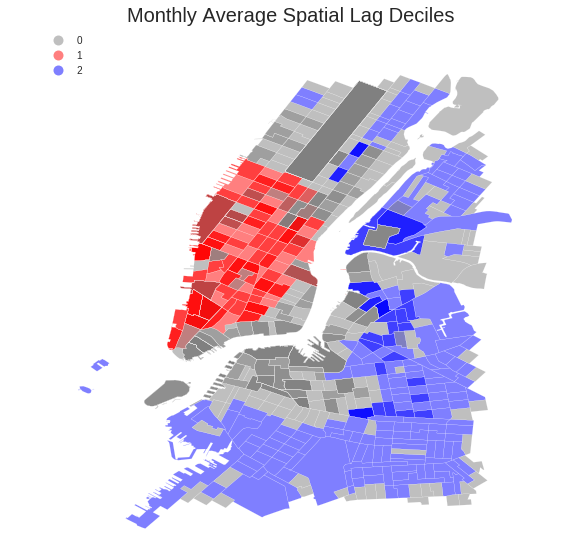

In [63]:
hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Average Spatial Lag Deciles", size = 20)
plt.show()

**Figure 12: Map of Monthly Average Spatial Lag**. This map shows the cold and hot spots of rides by Censor track. It can be seen that Manhattan mostly is hot spot whereas Brooklyn and Harlem and Upper East side is cold.

That makes sense, considering that cold areas are where Citibike is not installed and hot areas are in fact where are the stations installed.
